In [76]:
# Cell 0: Installations
#%pip install scikit-learn scikit-image
#%pip install SimpleITK
%pip install nibabel nilearn scipy scikit-image

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 10.4/10.4 MB 59.0 MB/s eta 0:00:00
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 3.8/3.8 MB 56.4 MB/s eta 0:00:00
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Cell 1: Import necessary libraries
import os
import pandas as pd

In [2]:
# Cell 2: Define the base directory and categories
# Assuming the notebook and Images folder are in the same directory
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']

In [3]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                data.append({
                                    'category': category,
                                    'patient_id': patient_id,
                                    'file_path': file_path
                                })


In [4]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]
df.head()


,patient_id,file_path,label
0,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
1,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
2,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
3,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
4,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD


In [5]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())


Number of images per category:
label
PD         3364
Control     378
SWEDD       137
Name: count, dtype: int64


In [6]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)


In [7]:
# Cell 7: Import additional libraries for image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars


In [8]:
# Cell 8: Function to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Resize image if target_shape is specified
    if target_shape and img.shape != target_shape:
        from skimage.transform import resize
        img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img


In [9]:
# Cell 9: Initialize dictionaries to store sums and counts for each group
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}
shapes = {'PD': None, 'SWEDD': None, 'Control': None}


In [10]:
# Cell 10: Compute mean images for each group
# We'll iterate over the DataFrame 'df' created earlier

# Map labels to group names
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

# Iterate over each group
for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    # Initialize progress bar
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Load the image
            if counts[label] == 0:
                # For the first image, get the shape
                img = load_dicom_image(file_path)
                shapes[label] = img.shape
                mean_sums[label] = np.zeros(shapes[label], dtype=np.float32)
            else:
                # For subsequent images, resize if necessary
                img = load_dicom_image(file_path, target_shape=shapes[label])
            
            # Accumulate the sum
            mean_sums[label] += img
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    mean_sums[label] /= counts[label]


Processing group: PD


100%|██████████| 3364/3364 [00:32<00:00, 102.47it/s]


Processing group: SWEDD


100%|██████████| 137/137 [00:00<00:00, 216.70it/s]


Processing group: Control


100%|██████████| 378/378 [00:03<00:00, 104.68it/s]


In [11]:
# Cell 11 (Updated): Visualize the mean images for each group with corrected orientation
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image with corrected orientation.
    Each image is rotated counterclockwise by 90 degrees.
    """
    # Swap axes if necessary to match anatomical planes
    # This rearranges the data from (Z, Y, X) to (X, Y, Z)
    mean_img = np.swapaxes(mean_img, 0, 2)

    # Compute the middle slices
    axial_slice = mean_img[:, :, mean_img.shape[2] // 2]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[mean_img.shape[0] // 2, :, :]

    # Adjust the orientation of slices
    # First, flip slices to correct the orientation
    axial_slice = np.flipud(axial_slice)
    coronal_slice = np.flipud(coronal_slice)
    sagittal_slice = np.flipud(sagittal_slice)

    # Then, rotate each slice counterclockwise by 90 degrees
    axial_slice = np.rot90(axial_slice, k=1)
    coronal_slice = np.rot90(coronal_slice, k=1)
    sagittal_slice = np.rot90(sagittal_slice, k=1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")

    axes[0].imshow(axial_slice, cmap='gray', origin='upper')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice, cmap='gray', origin='upper')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice, cmap='gray', origin='upper')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


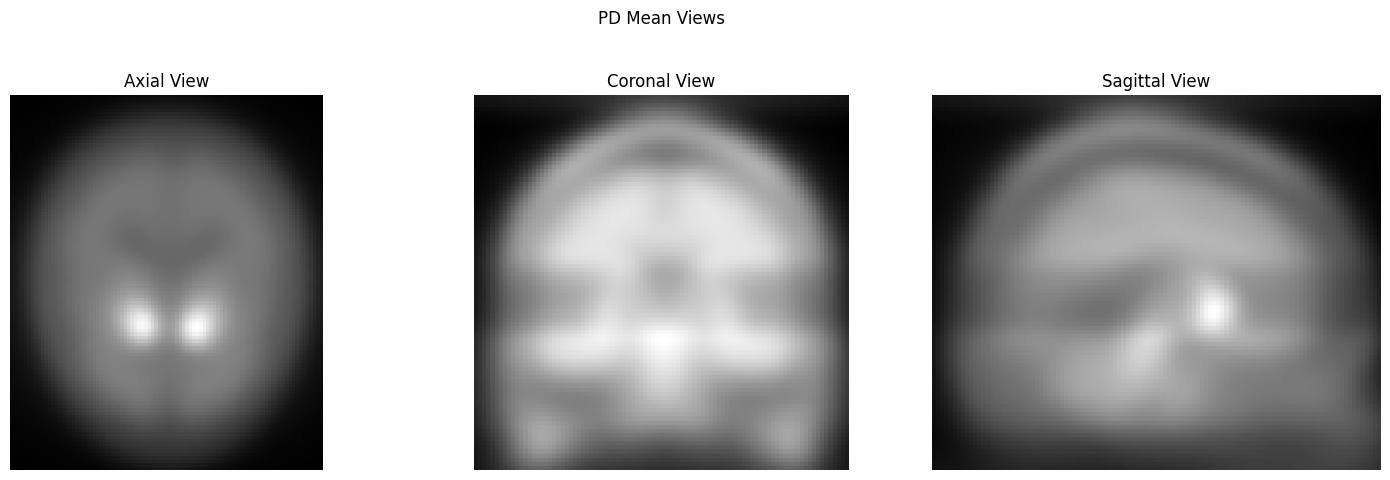

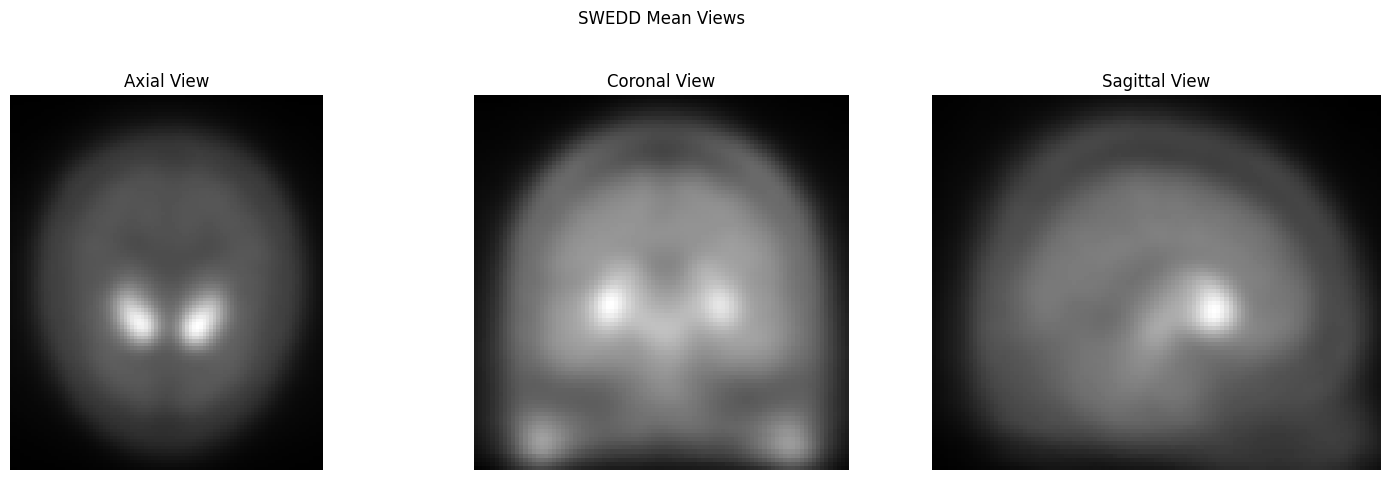

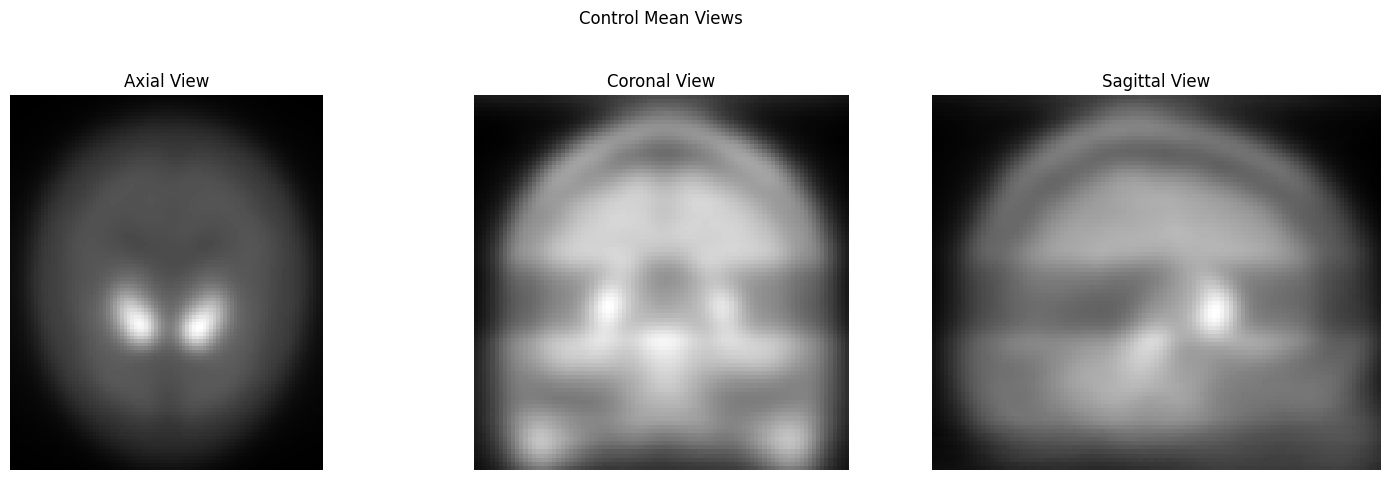

In [12]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)


In [13]:
# Cell 13: Select and visualize a random patient from each group

import random

# Function to select a random patient from each group
def select_random_patients(df, groups):
    random_patients = {}
    for group in groups:
        group_df = df[df['label'] == group]
        unique_patients = group_df['patient_id'].unique()
        if len(unique_patients) == 0:
            print(f"No patients found in group: {group}")
            continue
        selected_patient = random.choice(unique_patients)
        random_patients[group] = selected_patient
    return random_patients

# Define the groups
groups = ['PD', 'SWEDD', 'Control']

# Select random patients
random_patients = select_random_patients(df, groups)
print("Selected Random Patients:")
for group, patient in random_patients.items():
    print(f"{group}: Patient ID {patient}")

Selected Random Patients:
PD: Patient ID 3132
SWEDD: Patient ID 3255
Control: Patient ID 3438


Visualizing Patient ID 3132 - File: Images\PPMI_Images_PD\3132\Reconstructed_DaTSCAN\2014-03-27_13_04_06.0\I436066\PPMI_3132_NM_Reconstructed_DaTSCAN_Br_20140721163213128_1_S225352_I436066.dcm


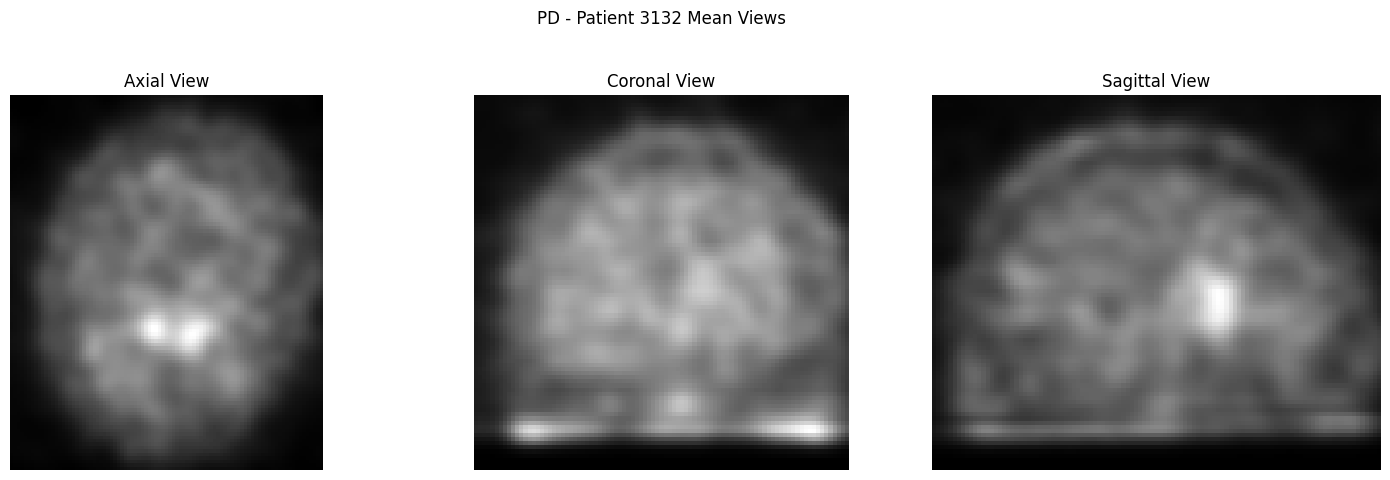

Visualizing Patient ID 3255 - File: Images\PPMI_Images_SWEDD\3255\Reconstructed_DaTSCAN\2011-06-30_15_46_59.0\I341065\PPMI_3255_NM_Reconstructed_DaTSCAN_Br_20121018134443784_1_S117584_I341065.dcm


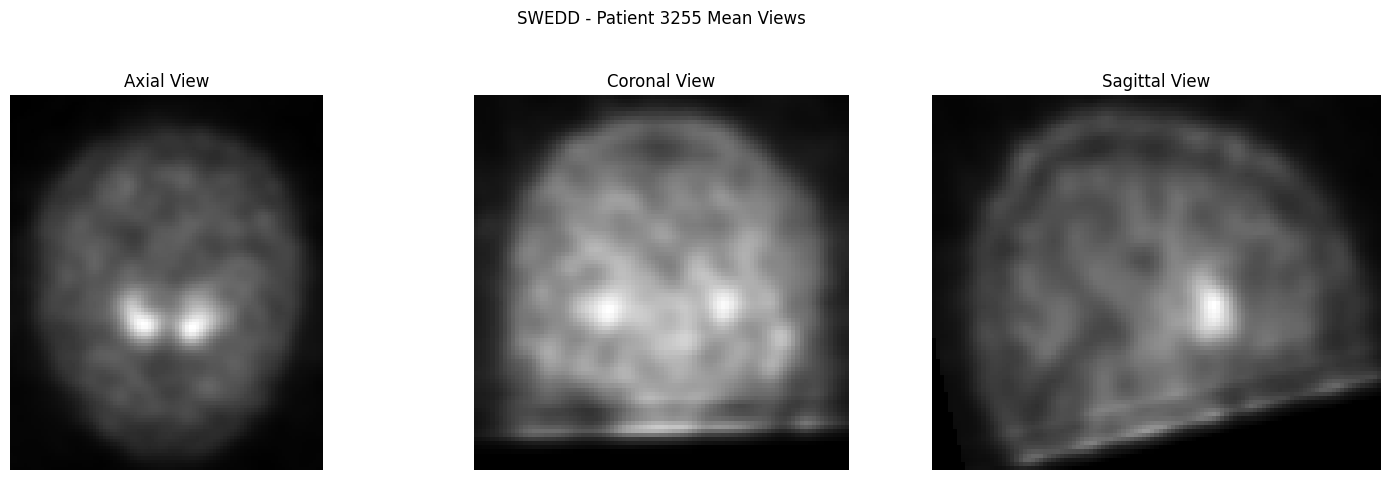

Visualizing Patient ID 3438 - File: Images\PPMI_Images_Cont\3438\Reconstructed_DaTSCAN\2011-11-10_13_09_01.0\I340388\PPMI_3438_NM_Reconstructed_DaTSCAN_Br_20121016145549267_1_S131284_I340388.dcm


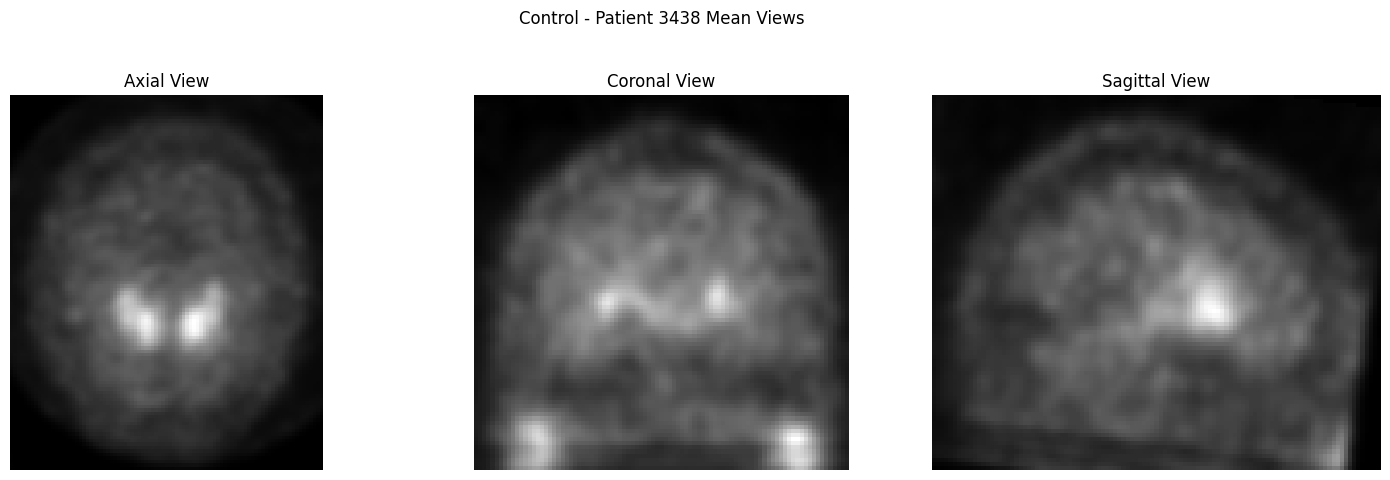

In [14]:
# Function to visualize a random image for a given patient
def visualize_random_patient(df, patient_id, label):
    """
    Select a random DICOM file for the given patient and plot its views.
    """
    patient_df = df[(df['patient_id'] == patient_id) & (df['label'] == label)]
    if patient_df.empty:
        print(f"No images found for Patient ID {patient_id} in group {label}.")
        return
    
    # Select a random image
    random_file = random.choice(patient_df['file_path'].tolist())
    print(f"Visualizing Patient ID {patient_id} - File: {random_file}")
    
    # Load the image
    img = load_dicom_image(random_file)
    
    # Plot the views
    plot_mean_views(img, title_prefix=f"{label} - Patient {patient_id}")

# Iterate over each group and visualize a random patient
for group, patient_id in random_patients.items():
    visualize_random_patient(df, patient_id, group)


# EDA

In [15]:
# Cell 14: Import additional libraries for advanced analysis
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
from nilearn import plotting
import nibabel as nib
from concurrent.futures import ThreadPoolExecutor
import gc
import psutil
import time
import gc

In [16]:
# Cell 15: Configure GPU settings and memory monitoring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def get_memory_usage():
    """
    Get current memory usage of the system and GPU if available
    """
    # System memory
    process = psutil.Process()
    system_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    # GPU memory
    gpu_memory = None
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
    
    return system_memory, gpu_memory

if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU Name: {torch.cuda.get_device_name()}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set memory management options
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Available: 12.88 GB


In [17]:
# Cell 16: Enhanced image statistics computation with memory tracking
def compute_image_statistics(img):
    """
    Compute comprehensive statistics for a 3D image
    """
    stats_dict = {
        'mean': float(np.mean(img)),  # Convert to native Python types
        'std': float(np.std(img)),
        'min': float(np.min(img)),
        'max': float(np.max(img)),
        'median': float(np.median(img)),
        'skewness': float(stats.skew(img.flatten())),
        'kurtosis': float(stats.kurtosis(img.flatten())),
        'num_zeros': int(np.sum(img == 0)),
        'num_non_zeros': int(np.sum(img != 0)),
        'volume': int(img.size),
        'dimensions': img.shape
    }
    
    # Compute histogram data
    hist, bins = np.histogram(img.flatten(), bins=50)
    stats_dict['histogram'] = {
        'counts': hist.tolist(),  # Convert to list for better memory management
        'bins': bins.tolist()
    }
    
    return stats_dict

In [18]:
# Cell 17: Batch process images with improved memory management
def process_group_statistics(group_df, batch_size=5):
    """
    Process images in batches with memory monitoring
    """
    statistics = []
    
    # Create progress bar for the entire dataset
    with tqdm(total=len(group_df), desc="Processing images") as pbar:
        for start_idx in range(0, len(group_df), batch_size):
            end_idx = min(start_idx + batch_size, len(group_df))
            batch_df = group_df.iloc[start_idx:end_idx]
            
            for _, row in batch_df.iterrows():
                try:
                    img = load_dicom_image(row['file_path'])
                    stats = compute_image_statistics(img)
                    stats['patient_id'] = row['patient_id']
                    statistics.append(stats)
                    del img
                except Exception as e:
                    tqdm.write(f"Error processing {row['file_path']}: {e}")
                
                pbar.update(1)
            
            # Clean up memory after batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return statistics

In [19]:
# Cell 18: Process statistics for each group with progress tracking
group_statistics = {}
for label in group_labels.values():
    print(f"\nProcessing statistics for {label} group...")
    start_time = time.time()
    
    group_df = df[df['label'] == label]
    group_statistics[label] = process_group_statistics(group_df)
    
    duration = time.time() - start_time
    print(f"Completed {label} group in {duration:.2f} seconds")
    print(f"Processed {len(group_statistics[label])} images")


Processing statistics for PD group...


Processing images: 100%|██████████| 3364/3364 [02:48<00:00, 20.02it/s]


Completed PD group in 168.03 seconds
Processed 3364 images

Processing statistics for SWEDD group...


Processing images: 100%|██████████| 137/137 [00:06<00:00, 22.00it/s]


Completed SWEDD group in 6.23 seconds
Processed 137 images

Processing statistics for Control group...


Processing images: 100%|██████████| 378/378 [00:18<00:00, 20.53it/s]

Completed Control group in 18.41 seconds
Processed 378 images


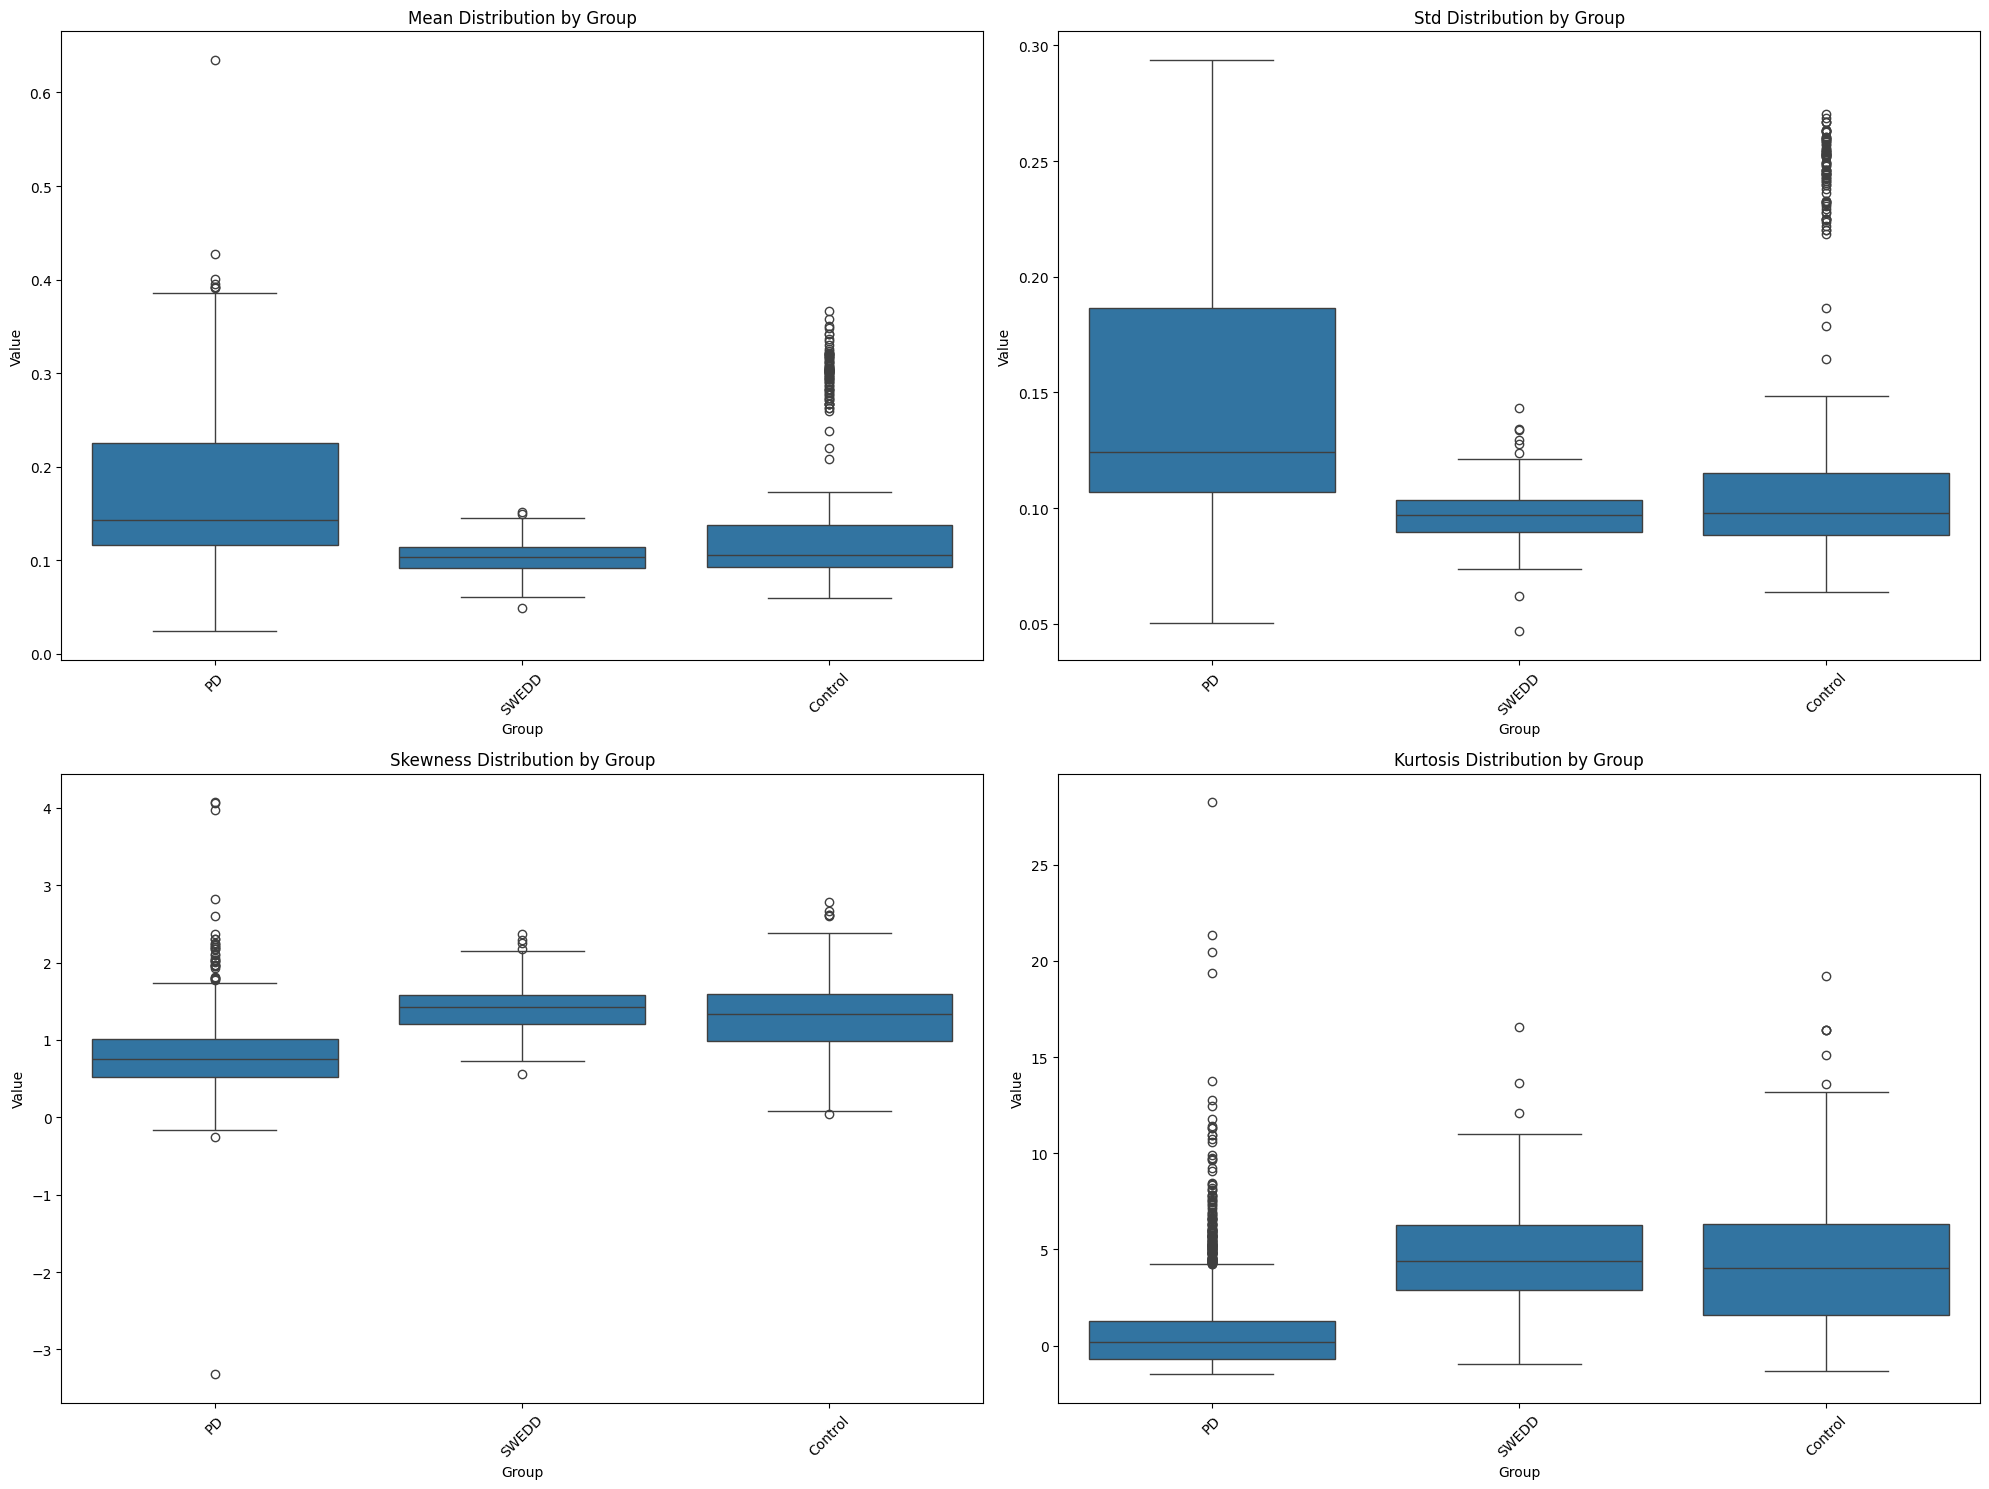

In [20]:
# Cell 19: Visualize statistical distributions with efficient memory usage
def plot_group_statistics(group_statistics):
    """
    Create comparison plots for different statistical measures across groups
    """
    metrics = ['mean', 'std', 'skewness', 'kurtosis']
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        plot_data = []
        group_names = []
        
        for group in group_labels.values():
            values = [s[metric] for s in group_statistics[group]]
            plot_data.extend(values)
            group_names.extend([group] * len(values))
        
        # Create DataFrame for seaborn
        import pandas as pd
        df_plot = pd.DataFrame({
            'Group': group_names,
            'Value': plot_data
        })
        
        # Create boxplot using the correct syntax
        sns.boxplot(data=df_plot, x='Group', y='Value', ax=ax)
        ax.set_title(f'{metric.capitalize()} Distribution by Group')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Clean up
    plt.close('all')
    gc.collect()

plot_group_statistics(group_statistics)

## Mean Distribution by Group

The average intensity values of voxels in the brain scans for each group (PD, SWEDD, Control).

- **Higher means** indicate brighter regions overall in the scan.
  - In DAT scans, this is particularly important because dopamine transporters show up as bright areas.
  - **Lower mean values** in PD patients often indicate loss of dopamine transporters.
  - SWEDD patients (Scans Without Evidence of Dopaminergic Deficit) should show values more similar to controls.
- The box shows where **50% of your data** falls, with the middle line being the **median**.
- Whiskers show the range of "normal" values, and dots are **outliers**.

## Standard Deviation (Std) Distribution by Group

How much variation or dispersion exists in the voxel intensities.

- **Higher std** means more contrast between different regions in the brain.
- **Lower std** suggests more uniform intensity across the scan.
- In PD patients:
  - Lower std may reflect loss of the normally bright dopamine transporter regions.
- **Controls** should show higher std due to clear distinction between regions with and without dopamine transporters.
- **SWEDD patients** should be similar to controls in this measure.

## Skewness Distribution by Group

The asymmetry of the intensity distribution.

- **Positive skewness** (value > 0) means there's a long tail of high values.
- **Negative skewness** (value < 0) means there's a long tail of low values.
- In DAT scans:
  - **Controls** often show positive skewness due to the presence of bright dopamine transporter regions.
  - **PD patients** might show less positive skewness due to loss of these bright regions.
  - **SWEDD** should be similar to controls.
- This measure can help identify patterns in how the disease affects certain brain regions.

## Kurtosis Distribution by Group

The "tailedness" of the intensity distribution.

- **Higher kurtosis** means more extreme values (outliers).
- **Lower kurtosis** means the data is more uniformly distributed.
- In DAT scans:
  - **Controls** might show higher kurtosis due to the distinct contrast between regions.
  - **PD patients** might show lower kurtosis due to more uniform (and reduced) signal.
  - **SWEDD patients** should again be more similar to controls.
- This can help identify how distinct the dopamine transporter regions are from background tissue.

In [21]:
# Cell 20: Analyze spatial characteristics with memory optimization
def compute_spatial_features(img):
    """
    Analyze spatial characteristics of 3D images with memory optimization
    """
    # Compute gradients one at a time to save memory
    gradients = []
    for axis in range(3):
        grad = np.gradient(img, axis=axis)
        gradients.append(grad)
        
    gradient_magnitude = np.sqrt(sum(grad**2 for grad in gradients))
    del gradients  # Free memory
    
    # Compute edge information using Sobel
    from scipy import ndimage
    edges = []
    for axis in range(3):
        edge = ndimage.sobel(img, axis=axis)
        edges.append(edge**2)
    
    edge_magnitude = np.sqrt(sum(edges))
    del edges  # Free memory
    
    # Compute statistics
    spatial_stats = {
        'gradient_stats': compute_image_statistics(gradient_magnitude),
        'edge_stats': compute_image_statistics(edge_magnitude)
    }
    
    # Clean up
    del gradient_magnitude, edge_magnitude
    gc.collect()
    
    return spatial_stats

In [22]:
# Cell 21: Analyze ROI characteristics with memory efficiency
def analyze_roi_characteristics(img, threshold=0.5):
    """
    Analyze characteristics of regions of interest with memory optimization
    """
    # Create binary mask
    binary_mask = img > threshold
    del img  # Free original image memory if not needed
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_mask)
    del binary_mask  # Free binary mask memory
    
    roi_properties = {
        'num_regions': num_features,
        'volumes': [],
        'centroids': [],
        'mean_intensities': []
    }
    
    # Process each ROI
    for label in range(1, num_features + 1):
        region_mask = labeled_array == label
        roi_properties['volumes'].append(int(np.sum(region_mask)))
        roi_properties['centroids'].append(tuple(map(float, ndimage.center_of_mass(region_mask))))
        roi_properties['mean_intensities'].append(float(np.mean(img[region_mask])))
        del region_mask  # Free mask memory after each iteration
    
    del labeled_array  # Free labeled array memory
    gc.collect()
    
    return roi_properties

In [23]:
# Cell 22: Visualize ROI distribution with batch processing
def plot_roi_distributions(group_statistics):
    plt.figure(figsize=(15, 5))
    
    for idx, (group, stats) in enumerate(group_statistics.items()):
        roi_volumes = []
        
        # Process in smaller batches
        batch_size = 10
        for i in range(0, len(stats), batch_size):
            batch_stats = stats[i:i + batch_size]
            
            for stat in batch_stats:
                img = load_dicom_image(df[df['patient_id'] == stat['patient_id']].iloc[0]['file_path'])
                roi_props = analyze_roi_characteristics(img)
                roi_volumes.extend(roi_props['volumes'])
                del img, roi_props
                gc.collect()
        
        plt.subplot(1, 3, idx+1)
        sns.histplot(roi_volumes, bins=30)
        plt.title(f'ROI Volume Distribution - {group}')
        plt.xlabel('Volume (voxels)')
        plt.ylabel('Count')
        
        del roi_volumes
        gc.collect()
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [24]:
# Cell 23: Save processed statistics with compression
import pickle
import gzip

# Save statistics to compressed file for better storage
with gzip.open('group_statistics.pkl.gz', 'wb') as f:
    pickle.dump(group_statistics, f)

In [25]:
# Cell 24: Print summary report
print("\nEDA Summary Report")
print("-----------------")
for group, stats in group_statistics.items():
    print(f"\n{group} Group:")
    print(f"Number of samples: {len(stats)}")
    
    # Calculate aggregate statistics
    means = np.mean([s['mean'] for s in stats])
    stds = np.mean([s['std'] for s in stats])
    skew = np.mean([s['skewness'] for s in stats])
    kurt = np.mean([s['kurtosis'] for s in stats])
    
    print(f"Average intensity: {means:.2f} ± {stds:.2f}")
    print(f"Average skewness: {skew:.2f}")
    print(f"Average kurtosis: {kurt:.2f}")
    
    # Print memory usage
    sys_mem, gpu_mem = get_memory_usage()
    print(f"Current system memory usage: {sys_mem:.2f} MB")
    if gpu_mem is not None:
        print(f"Current GPU memory usage: {gpu_mem:.2f} MB")


EDA Summary Report
-----------------

PD Group:
Number of samples: 3364
Average intensity: 0.18 ± 0.15
Average skewness: 0.78
Average kurtosis: 0.63
Current system memory usage: 610.60 MB
Current GPU memory usage: 0.00 MB

SWEDD Group:
Number of samples: 137
Average intensity: 0.10 ± 0.10
Average skewness: 1.42
Average kurtosis: 4.73
Current system memory usage: 610.61 MB
Current GPU memory usage: 0.00 MB

Control Group:
Number of samples: 378
Average intensity: 0.15 ± 0.13
Average skewness: 1.29
Average kurtosis: 4.16
Current system memory usage: 610.62 MB
Current GPU memory usage: 0.00 MB


## Statistical Analysis of DATSCAN Images Across Patient Groups

### Dataset Composition
The analysis encompasses a total of 3,879 DATSCAN images distributed across three groups:
- Parkinson's Disease (PD): 3,364 samples (86.7%)
- SWEDD: 137 samples (3.5%)
- Control: 378 samples (9.7%)

It's worth noting that there is a significant class imbalance in the dataset, with PD cases representing the vast majority of the samples. This imbalance should be considered during model development and validation phases.

### Intensity Analysis

#### Average Intensities (μ ± σ)
- PD Group: 0.18 ± 0.15
- SWEDD Group: 0.10 ± 0.10
- Control Group: 0.15 ± 0.13

The intensity patterns reveal several interesting findings:
1. PD patients show the highest average intensity (0.18), which is somewhat counterintuitive as we would typically expect lower dopamine transporter activity in PD patients. This might suggest:
   - Potential compensation mechanisms in the brain
   - Variations in image acquisition or normalization
   - The need for region-specific analysis rather than global intensity measurements

2. SWEDD cases show the lowest average intensity (0.10), despite being clinically similar to controls. This unexpected finding might:
   - Explain why these cases show no evidence of dopaminergic deficit in clinical assessment
   - Indicate different underlying pathophysiology
   - Suggest the need for more sophisticated analysis methods beyond simple intensity measures

3. Control cases show intermediate values (0.15), which:
   - Provides a useful baseline for comparison
   - Suggests complex patterns that might not be captured by simple intensity metrics alone

### Distribution Characteristics:

#### Skewness Analysis
- PD Group: 0.78
- SWEDD Group: 1.42
- Control Group: 1.29

The skewness values offer valuable insights:
1. All groups show positive skewness, indicating right-tailed distributions (more low-intensity values with a tail toward higher intensities)
2. SWEDD and Control groups show notably higher skewness (1.42 and 1.29 respectively) compared to PD (0.78)
3. This pattern suggests:
   - More uniform intensity distribution in PD cases, possibly due to loss of contrast in dopamine transporter regions
   - Similar intensity patterns between SWEDD and Control groups, despite differences in average intensity
   - Potential biomarker patterns in the intensity distribution shape

#### Kurtosis Analysis
- PD Group: 0.63
- SWEDD Group: 4.73
- Control Group: 4.16

The kurtosis values reveal striking differences:
1. PD cases show markedly lower kurtosis (0.63) compared to both other groups
2. SWEDD and Control groups show similar, higher kurtosis values (4.73 and 4.16 respectively)
3. These patterns indicate:
   - More uniform intensity distribution in PD cases (platykurtic)
   - More extreme values in both SWEDD and Control cases (leptokurtic)
   - Potential loss of distinct dopamine transporter regions in PD cases

## Clinical Implications

These statistical findings have several important implications for clinical practice and research:

1. **Diagnostic Potential**:
   - The distinct kurtosis values between PD and non-PD cases suggest potential diagnostic value
   - The similarity between SWEDD and Control distributions might help explain clinical misdiagnoses

2. **Group Characteristics**:
   - PD cases show more uniform intensity distributions (lower skewness and kurtosis)
   - SWEDD and Control cases show more varied distributions with more extreme values

3. **Future Directions**:
   - Region-specific analysis might reveal more detailed patterns
   - Machine learning models should consider these distribution characteristics
   - The class imbalance should be addressed in model development

# Preprocessing

In [ ]:
# Cell 25: Import necessary libraries with memory monitoring
import os
import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import zoom
from skimage import exposure
from tqdm import tqdm
import psutil
import gc

def get_memory_info():
    """Monitor both system and GPU memory"""
    gpu_memory = f"{torch.cuda.memory_allocated()/1024**2:.2f}MB" if torch.cuda.is_available() else "N/A"
    system_memory = f"{psutil.Process().memory_info().rss/1024**2:.2f}MB"
    return f"System Memory: {system_memory}, GPU Memory: {gpu_memory}"

In [ ]:
# Cell 26: Create DataLoader for memory-efficient processing
class DATSCANDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels=None, target_shape=(128, 128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.target_shape = target_shape
        
        # Verify files exist
        print("\nVerifying file paths...")
        for i, path in enumerate(tqdm(self.file_paths, desc="Checking files")):
            if not os.path.exists(path):
                print(f"\nWarning: File does not exist: {path}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        try:
            # Load DICOM image
            img = load_dicom_image(self.file_paths[idx])
            
            # Preprocess image
            img = self.preprocess_single_image(img)
            
            if self.labels is not None:
                return torch.FloatTensor(img), self.labels[idx]
            return torch.FloatTensor(img)
        except Exception as e:
            print(f"\nError processing image {idx} ({self.file_paths[idx]}): {str(e)}")
            # Return zero tensor if processing fails
            return torch.zeros(self.target_shape)

    def preprocess_single_image(self, img):
        """Preprocess a single image with memory efficiency"""
        # Convert to float32 early to save memory
        img = img.astype(np.float32)
        
        # Normalize intensity using percentile clipping
        p2, p98 = np.percentile(img, (2, 98))
        img = np.clip(img, p2, p98)
        img = (img - p2) / (p98 - p2)
        
        # Resize if necessary
        if img.shape != self.target_shape:
            resize_factors = [t/s for t, s in zip(self.target_shape, img.shape)]
            img = zoom(img, resize_factors, order=1, mode='reflect')
        
        return img

In [ ]:
# Cell 27: Memory-efficient preprocessing class
class DATSCANPreprocessor:
    def __init__(self, target_shape=(128, 128, 128), batch_size=4, num_workers=4):
        self.target_shape = target_shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize statistics
        self.mean = None
        self.std = None

    def compute_statistics(self, dataloader):
        """Compute dataset statistics in a memory-efficient way with detailed progress reporting"""
        print("\nComputing dataset statistics...")
        
        # First pass: count total batches
        total_images = len(dataloader.dataset)
        print(f"Total images to process: {total_images}")
        
        sum_vals = 0.0
        sum_sq_vals = 0.0
        count = 0
        processed_images = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(dataloader, desc="Computing statistics", 
                                                 unit="batch", dynamic_ncols=True)):
                try:
                    # Process batch
                    if isinstance(batch, tuple):
                        batch = batch[0]  # Extract images if (images, labels) tuple
                    
                    batch = batch.to(self.device)
                    sum_vals += torch.sum(batch).item()
                    sum_sq_vals += torch.sum(batch**2).item()
                    count += batch.numel()
                    
                    # Update progress
                    processed_images += batch.size(0)
                    if batch_idx % 10 == 0:
                        print(f"\rProcessed {processed_images}/{total_images} images "
                              f"({(processed_images/total_images)*100:.1f}%) - "
                              f"Memory: {get_memory_info()}", end="")
                    
                    # Clear GPU memory after each batch
                    del batch
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                except Exception as e:
                    print(f"\nError processing batch {batch_idx}: {str(e)}")
                    continue

        print("\n\nComputing final statistics...")
        self.mean = sum_vals / count
        self.std = np.sqrt(sum_sq_vals / count - self.mean**2)
        print(f"Dataset statistics computed - Mean: {self.mean:.4f}, Std: {self.std:.4f}")

    def create_dataloaders(self, df, train_size=0.8):
        """Create train/val dataloaders with memory efficiency"""
        print("\nPreparing data loaders...")
        
        # Create label mapping
        print("Creating label mapping...")
        label_mapping = {'PD': 0, 'SWEDD': 1, 'Control': 2}
        labels = torch.tensor([label_mapping[label] for label in tqdm(df['label'], desc="Processing labels")])
        
        # Split indices
        print("\nSplitting into train/validation sets...")
        num_samples = len(df)
        indices = torch.randperm(num_samples)
        train_size_num = int(train_size * num_samples)
        train_idx = indices[:train_size_num]
        val_idx = indices[train_size_num:]
        
        print(f"\nTrain set size: {len(train_idx)}")
        print(f"Validation set size: {len(val_idx)}")
        
        # Create datasets
        print("\nCreating training dataset...")
        train_dataset = DATSCANDataset(
            df.iloc[train_idx]['file_path'].tolist(),
            labels[train_idx],
            self.target_shape
        )
        
        print("\nCreating validation dataset...")
        val_dataset = DATSCANDataset(
            df.iloc[val_idx]['file_path'].tolist(),
            labels[val_idx],
            self.target_shape
        )
        
        # Create dataloaders
        print("\nInitializing data loaders...")
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        return train_loader, val_loader

    def process_and_save(self, df, save_dir='preprocessed_data'):
        """Process and save data in chunks"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Create dataloaders
        train_loader, val_loader = self.create_dataloaders(df)
        
        # Compute statistics on training data
        self.compute_statistics(train_loader)
        
        # Process and save training data
        self._save_data(train_loader, os.path.join(save_dir, 'train'))
        
        # Process and save validation data
        self._save_data(val_loader, os.path.join(save_dir, 'val'))
        
        # Save statistics
        torch.save({
            'mean': self.mean,
            'std': self.std
        }, os.path.join(save_dir, 'statistics.pt'))

    def _save_data(self, dataloader, save_path):
        """Save data in chunks with memory efficiency"""
        os.makedirs(save_path, exist_ok=True)
        
        for i, (images, labels) in enumerate(tqdm(dataloader, desc=f"Saving to {save_path}")):
            # Standardize batch
            images = (images - self.mean) / (self.std + 1e-8)
            
            # Save batch
            torch.save({
                'images': images.cpu(),
                'labels': labels.cpu()
            }, os.path.join(save_path, f'batch_{i}.pt'))
            
            # Clear memory
            del images, labels
            torch.cuda.empty_cache()
            gc.collect()

In [ ]:
# Cell 28: Run preprocessing pipeline
def run_preprocessing_pipeline(df):
    print("\nInitializing preprocessing pipeline...")
    print(f"Initial memory usage: {get_memory_info()}")
    print(f"Total images to process: {len(df)}")
    print(f"Available CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
    
    # Initialize preprocessor with very conservative batch size initially
    preprocessor = DATSCANPreprocessor(
        target_shape=(128, 128, 128),
        batch_size=2,  # Start with very small batch size
        num_workers=2  # Start with fewer workers
    )
    
    try:
        # Process and save data
        print("\nStarting data processing...")
        preprocessor.process_and_save(df)
        
        print(f"\nFinal memory usage: {get_memory_info()}")
        print("Preprocessing successfully completed!")
        
    except Exception as e:
        print(f"\nError during preprocessing: {str(e)}")
        print("Debug information:")
        print(f"Current memory usage: {get_memory_info()}")
        if torch.cuda.is_available():
            print(f"CUDA memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f}MB")
            print(f"CUDA memory cached: {torch.cuda.memory_reserved()/1024**2:.2f}MB")
        raise

In [ ]:
# Cell 29: Visualization helpers
def visualize_preprocessed_samples(save_dir, num_samples=3):
    """Visualize samples from preprocessed data"""
    import matplotlib.pyplot as plt
    
    # Load statistics
    stats = torch.load(os.path.join(save_dir, 'statistics.pt'))
    
    # Load and visualize samples from training data
    train_files = sorted(os.listdir(os.path.join(save_dir, 'train')))
    
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(min(num_samples, len(train_files))):
        data = torch.load(os.path.join(save_dir, 'train', train_files[i]))
        img = data['images'][0].numpy()  # Take first image from batch
        label = data['labels'][0].item()
        
        # Show middle slice of each dimension
        for j, axis in enumerate(['Sagittal', 'Coronal', 'Axial']):
            plt.subplot(num_samples, 3, i*3 + j + 1)
            slice_idx = img.shape[j] // 2
            if j == 0:
                plt.imshow(img[slice_idx, :, :], cmap='gray')
            elif j == 1:
                plt.imshow(img[:, slice_idx, :], cmap='gray')
            else:
                plt.imshow(img[:, :, slice_idx], cmap='gray')
            plt.title(f'{axis} View - Label: {label}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 30: Execute pipeline
if __name__ == "__main__":
    run_preprocessing_pipeline(df)
    visualize_preprocessed_samples('preprocessed_data')


Initializing preprocessing pipeline...
Initial memory usage: System Memory: 610.61MB, GPU Memory: 0.00MB
Total images to process: 3879
Available CUDA device: NVIDIA GeForce RTX 4070 Ti

Starting data processing...

Preparing data loaders...
Creating label mapping...


Processing labels: 100%|██████████| 3879/3879 [00:00<?, ?it/s]



Splitting into train/validation sets...

Train set size: 3103
Validation set size: 776

Creating training dataset...

Verifying file paths...


Checking files: 100%|██████████| 3103/3103 [00:00<00:00, 48429.97it/s]



Creating validation dataset...

Verifying file paths...


Checking files: 100%|██████████| 776/776 [00:00<00:00, 59138.03it/s]



Initializing data loaders...

Computing dataset statistics...
Total images to process: 3103


Computing statistics:   0%|          | 0/1552 [00:00<?, ?batch/s]

In [31]:
# Test single image loading
test_path = df['file_path'].iloc[0]
print(f"Testing path: {test_path}")
try:
    start_time = time.time()
    img = load_dicom_image(test_path)
    load_time = time.time() - start_time
    print(f"Successfully loaded image with shape {img.shape} in {load_time:.2f} seconds")
except Exception as e:
    print(f"Error loading image: {str(e)}")

Testing path: Images\PPMI_Images_PD\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm
Successfully loaded image with shape (91, 109, 91) in 0.00 seconds
